In [1]:
from fastai.vision import *
import glob
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils
from fastai.vision import *

In [2]:
path = Path('../dataset/1_vs_all/')

In [3]:
classes = ['No Pneumothorax','Pneumothorax']

In [4]:
tfms = get_transforms(max_rotate=30, max_zoom=1.3, max_lighting=0.4, max_warp=0,
                     p_affine=1., p_lighting=1.)

In [5]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
                                 ds_tfms=tfms, size=224, bs=16, num_workers=3).normalize()

In [6]:
data.classes

['All others', 'Pneumothorax']

In [7]:
data.batch_size

16

In [8]:
data.train_ds

LabelList (41408 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Pneumothorax,Pneumothorax,Pneumothorax,Pneumothorax,Pneumothorax
Path: ../dataset/1_vs_all

In [9]:
#from class weights definitions

weights = np.array(41408/(2*np.bincount(data.train_ds.y)),dtype=np.float16)

In [10]:
np.bincount(data.train_ds.y)

array([37162,  4246])

In [11]:
weights

array([0.557, 4.875], dtype=float16)

In [12]:
def _plot(i,j,ax):
    x,y = data.train_ds[420]
    x.show(ax, y=y)

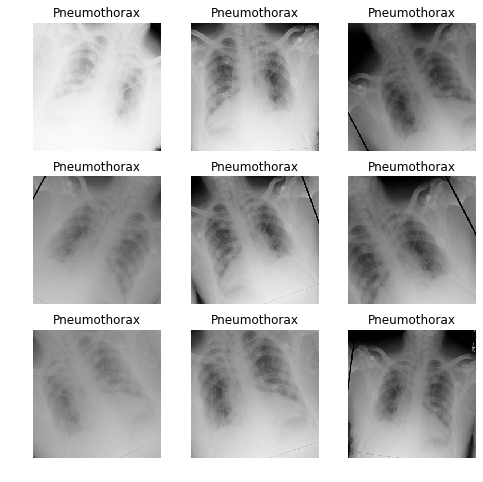

In [13]:
plot_multi(_plot, 3, 3, figsize=(8,8))

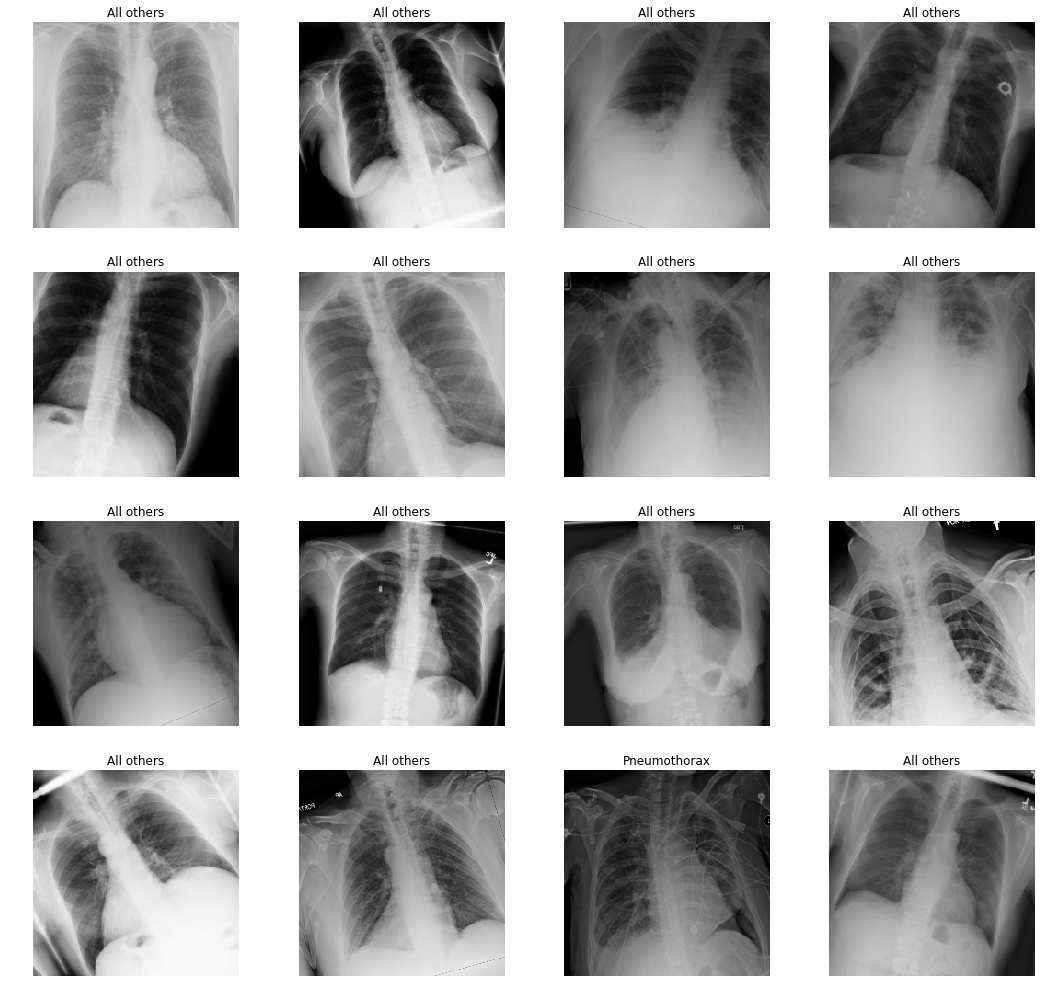

In [14]:
data.show_batch(rows=4, figsize=(15,14))

In [15]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['All others', 'Pneumothorax'], 2, 41408, 10351)

In [16]:
??torch.FloatTensor

Init signature: torch.FloatTensor(self, /, *args, **kwargs)
Docstring:      <no docstring>
File:           ~/anaconda3/envs/pytorch-env/lib/python3.7/site-packages/torch/__init__.py
Type:           tensortype
Subclasses:     


In [17]:
class_weights = torch.FloatTensor(weights).cuda()
loss_func = nn.CrossEntropyLoss(weight=class_weights)

In [18]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2, beta=1)

In [19]:
learner = cnn_learner(data, models.densenet121, pretrained=False, metrics=[accuracy,error_rate],
                     loss_func=loss_func)

/home/felipe/anaconda3/envs/pytorch-env/lib/python3.7/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


In [20]:
learner.loss_func

CrossEntropyLoss()

In [34]:
learner.unfreeze()

In [37]:
learner.lr_find(start_lr=5.75E-06,end_lr=3e-5)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 7.01E-06


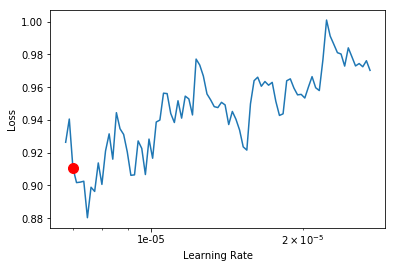

In [38]:
learner.recorder.plot(suggestion=True)

In [39]:
learner.fit_one_cycle(5,slice(5.75E-06,1e-5))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.884356,0.732727,0.442759,0.557241,26:31
1,0.853249,0.681172,0.612211,0.387789,29:02
2,0.813478,0.667511,0.682833,0.317167,28:47
3,0.799567,0.661230,0.707371,0.292629,28:41
4,0.813893,0.669371,0.693266,0.306734,28:32


In [47]:
doc(BCEWithLogitsFlat)

BCEWithLogitsFlat [source] [test] BCEWithLogitsFlat ( * args , axis : int = -1 , floatify : bool = True , ** kwargs ) 
 
 × No tests found for BCEWithLogitsFlat . To contribute a test please refer to this guide and this discussion . Same as nn.BCEWithLogitsLoss , but flattens input and target. 
 Show in docs

In [40]:
learner.save('DenseNet121-CELoss-stage-1')

In [21]:
learner.load('DenseNet121-CELoss-stage-1');

In [22]:
learner.unfreeze()

In [25]:
learner.lr_find(end_lr=1e-5)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


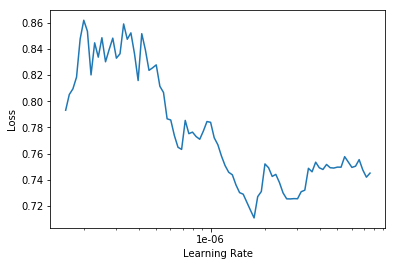

In [26]:
learner.recorder.plot()

In [27]:
learner.fit_one_cycle(5,slice(1e-6,2.5e-6))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.816489,0.662533,0.713361,0.286639,26:41
1,0.803392,0.658939,0.708531,0.291469,29:46
2,0.779814,0.661628,0.701285,0.298715,31:49
3,0.792965,0.662020,0.688146,0.311854,30:45
4,0.830130,0.664698,0.694329,0.305671,32:56


In [28]:
learner.save('DenseNet121-CELoss-stage-2')

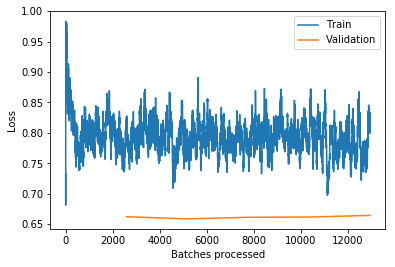

In [29]:
learner.recorder.plot_losses()

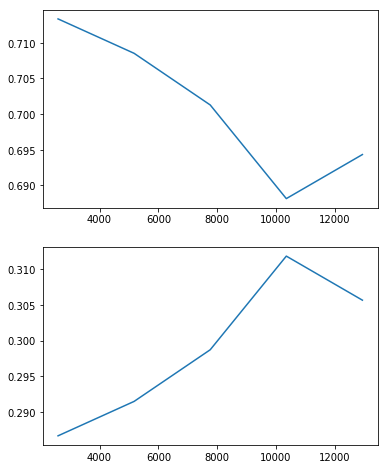

In [30]:
learner.recorder.plot_metrics()

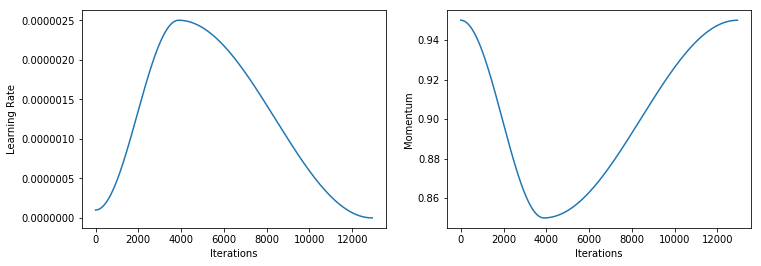

In [31]:
learner.recorder.plot_lr(show_moms=True)

In [32]:
learner.load('DenseNet121-CELoss-stage-2');

In [33]:
interp = ClassificationInterpretation.from_learner(learner)

In [34]:
410/999

0.41041041041041043

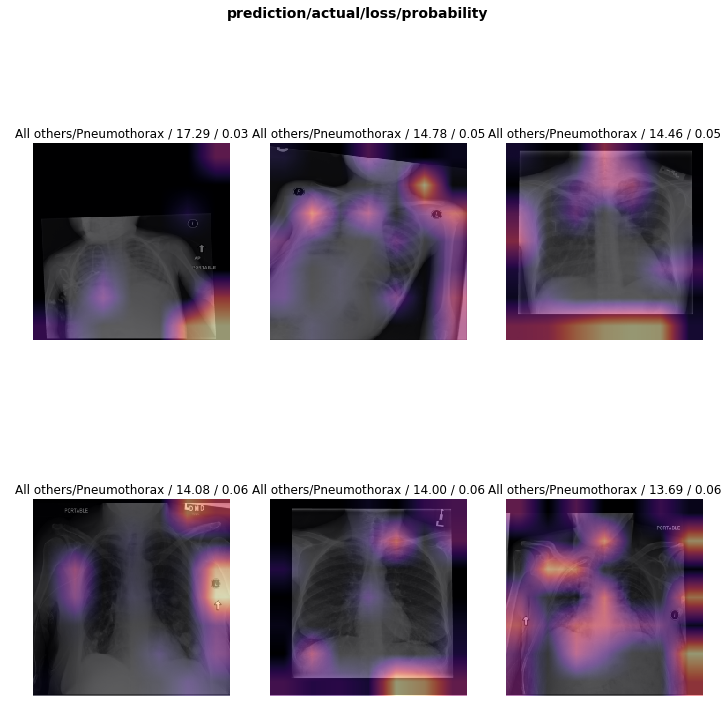

In [35]:
interp.plot_top_losses(6)

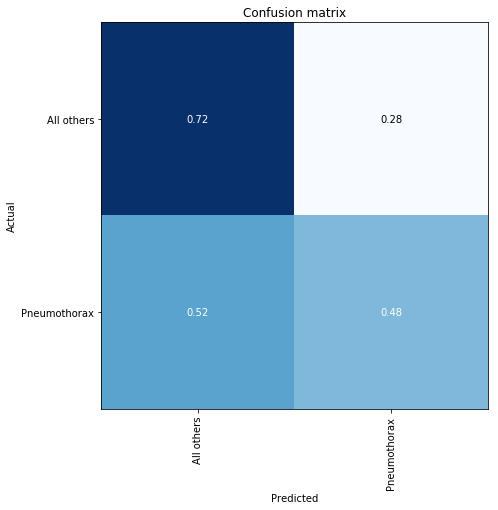

In [37]:
interp.plot_confusion_matrix(normalize=True,figsize=(7,7))

In [38]:
m = learner.model.eval();

Category All others

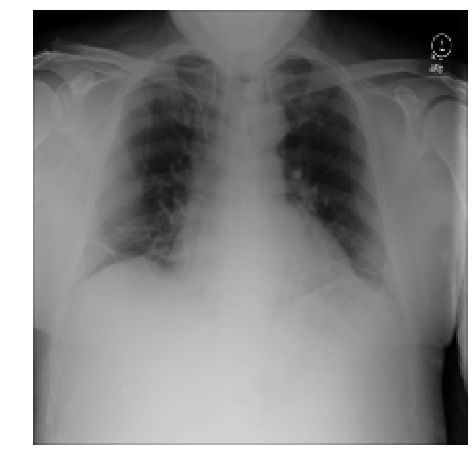

In [166]:
idx = 4200
x,y = data.valid_ds[idx]
x.show(figsize=(8,8))
data.valid_ds.y[idx]

In [157]:
x.shape

torch.Size([3, 224, 224])

In [158]:
xb, _ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

In [159]:
from fastai.callbacks.hooks import *

In [160]:
def hooked_backward(cat=y):
    with hook_output(m[0]) as hook_a:
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            preds[0, int(cat)].backward()
    return hook_a, hook_g

In [161]:
hook_a, hook_g = hooked_backward()

In [162]:
acts = hook_a.stored[0].cpu()
acts.shape

torch.Size([1024, 7, 7])

In [163]:
avg_acts = acts.mean(0)
avg_acts.shape

torch.Size([7, 7])

In [164]:
def show_heatmap(hm):
    fig, ax = plt.subplots(figsize=(8,8))
    xb_im.show(ax)
    ax.imshow(hm, alpha=0.6, extent=(0,224,224,0),
             interpolation='bilinear', cmap='magma')

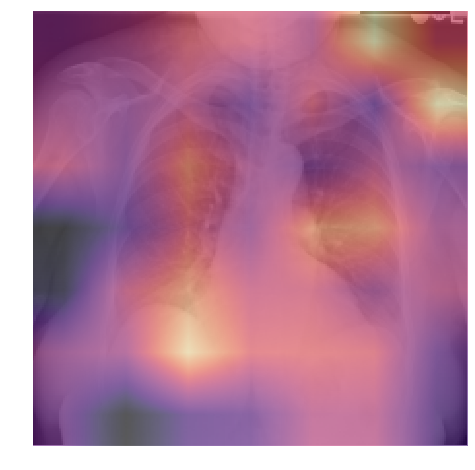

In [165]:
show_heatmap(avg_acts)

In [153]:
grad = hook_g.stored[0][0].cpu()
grad_chan = grad.mean(1).mean(1)
grad.shape, grad_chan.shape

(torch.Size([1024, 7, 7]), torch.Size([1024]))

In [154]:
mult = (acts*grad_chan[...,None,None]).mean(0)

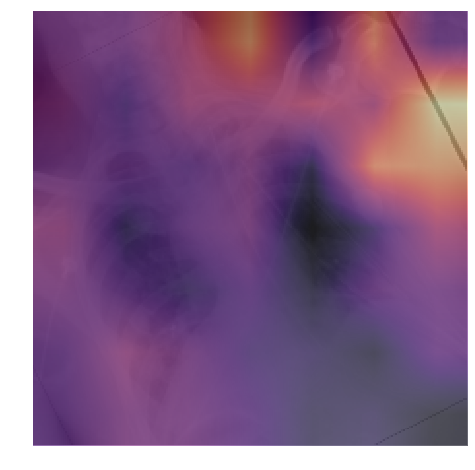

In [155]:
show_heatmap(mult)